#### NEURAL NETWORKS

Andeo, Lovely\
2020-05405\
FX-2

MovieWriter ffmpeg unavailable; using Pillow instead.


Epoch: 0, loss: 0.8146466005554285
Epoch: 0, loss: 0.5372843946964793
Epoch: 100, loss: 0.2854224580048572
Epoch: 200, loss: 0.28073532339375457
Epoch: 300, loss: 0.27500038734734117
Epoch: 400, loss: 0.26710486532640204
Epoch: 500, loss: 0.2555210272276248
Epoch: 600, loss: 0.237958189976436
Epoch: 700, loss: 0.2112902863543228
Epoch: 800, loss: 0.17443141786082783
Epoch: 900, loss: 0.13798091248473865
Epoch: 1000, loss: 0.117229941164187
Epoch: 1100, loss: 0.10926951383804362
Epoch: 1200, loss: 0.1060909294825914
Epoch: 1300, loss: 0.10443092574954392
Epoch: 1400, loss: 0.10330320754467519
Epoch: 1500, loss: 0.10237712314066227
Epoch: 1600, loss: 0.1015307418216754
Epoch: 1700, loss: 0.10071724717412327
Epoch: 1800, loss: 0.09991846217515979
Epoch: 1900, loss: 0.09912742853132331
Epoch: 2000, loss: 0.09834168294996193
Epoch: 2100, loss: 0.09756063042207738
Epoch: 2200, loss: 0.09678449438932947
Epoch: 2300, loss: 0.09601387253373
Epoch: 2400, loss: 0.09524952983486458
Epoch: 2500, lo

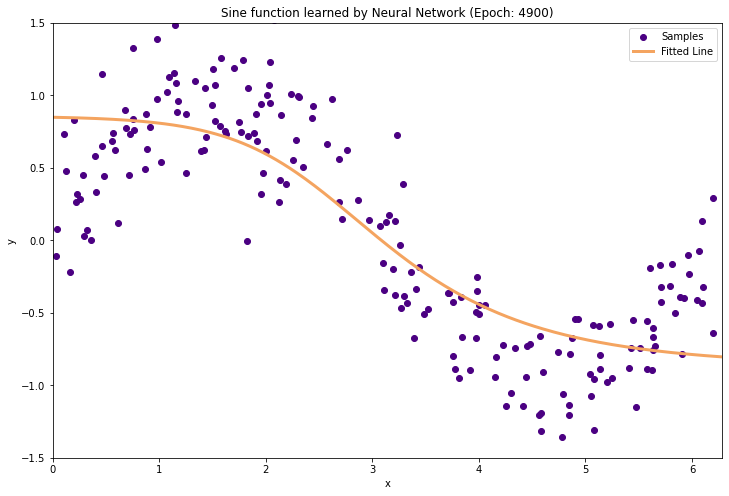

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

np.random.seed(42)
N_SAMPLES = 200
LAYERS = [1, 10, 10, 10, 1]
LEARNING_RATE = 0.1
N_EPOCHS = 5000

x_samples = np.random.uniform(0, 2 * np.pi, (1, N_SAMPLES))
y_samples = np.sin(x_samples) + np.random.normal(0.0, 0.3, (1, N_SAMPLES))

sigmoid = lambda x: 1.0 / (1.0 + np.exp(-x))
identity = lambda x: x

weight_matrices = []
bias_vectors = []
activation_functions = []

for fan_in, fan_out in zip(LAYERS[:-1], LAYERS[1:]):
    kernel_matrix_uniform_limit = np.sqrt(6 / (fan_in + fan_out))
    W = np.random.uniform(-kernel_matrix_uniform_limit, kernel_matrix_uniform_limit, (fan_out, fan_in))
    b = np.zeros((fan_out,))
    weight_matrices.append(W)
    bias_vectors.append(b)
    activation_functions.append(sigmoid)

activation_functions[-1] = identity

def network_forward(x, weights, biases, activations):
    a = x
    for W, b, activation in zip(weights, biases, activations):
        z = np.dot(W, a) + b[:, np.newaxis]  # Add an axis to b for proper broadcasting
        a = activation(z)
    return a

def loss_forward(y, y_ref):
    delta = y - y_ref
    loss = 0.5 * np.mean(np.sum(delta**2, axis=0))
    return loss

def loss_backward(y, y_ref):
    delta = y - y_ref
    N = y.shape[1]
    return delta / N

def network_forward_and_backward(x, y_ref, weights, biases, activations, activations_derivatives):
    a = x
    layer_values = [a, ]
    for W, b, activation in zip(weights, biases, activations):
        z = np.dot(W, a) + b[:, np.newaxis]  # Add an axis to b for proper broadcasting
        a = activation(z)
        layer_values.append(a)
    y = a
    loss = loss_forward(y, y_ref)

    current_cotangent = loss_backward(y, y_ref)
    weights_gradients = []
    bias_gradients = []

    for W, activation_prime, a_current, a_prev in zip(reversed(weights), reversed(activations_derivatives),
                                                      reversed(layer_values[1:]), reversed(layer_values[:-1])):
        activated_state_cotangent = current_cotangent
        plus_bias_state_cotangent = activated_state_cotangent * activation_prime(a_current)
        bias_grad = np.sum(plus_bias_state_cotangent, axis=1)
        state_cotangent = plus_bias_state_cotangent
        weight_grad = np.dot(state_cotangent, a_prev.T)
        prev_activated_state_cotangent = np.dot(W.T, state_cotangent)
        weights_gradients.append(weight_grad)
        bias_gradients.append(bias_grad)

        current_cotangent = prev_activated_state_cotangent

    return loss, list(reversed(weights_gradients)), list(reversed(bias_gradients))

sigmoid_prime = lambda x: x * (1 - x)
identity_prime = lambda x: 1.0

activations_derivatives = [sigmoid_prime for _ in range(len(LAYERS) - 2)] + [identity_prime]

fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(x_samples.flatten(), y_samples.flatten(), c='indigo', label="Samples")
line, = ax.plot([], [], color='sandybrown', linewidth=3, label="Fitted Line")
ax.set_xlim(0, 2 * np.pi)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

weight_grads_anim = []
bias_grads_anim = []

def update(frame):
    loss, weight_grads, bias_grads = network_forward_and_backward(
        x_samples,
        y_samples,
        weight_matrices,
        bias_vectors,
        activation_functions,
        activations_derivatives,
    )
    for W, W_grad, b, b_grad in zip(weight_matrices, weight_grads, bias_vectors, bias_grads):
        W -= LEARNING_RATE * W_grad
        b -= LEARNING_RATE * b_grad
    weight_grads_anim.append(weight_grads)
    bias_grads_anim.append(bias_grads)

    if frame % 100 == 0:
        print(f"Epoch: {frame}, loss: {loss}")
        y_pred_line = network_forward(
            x_line,
            weight_matrices,
            bias_vectors,
            activation_functions,
        )
        line.set_data(x_line.flatten(), y_pred_line.flatten())
        ax.set_title('Sine function learned by Neural Network (Epoch: {})'.format(frame))
        ax.legend()

x_line = np.linspace(0, 2 * np.pi, num=300).reshape((1, 300))
y_pred_line = network_forward(x_line, weight_matrices, bias_vectors, activation_functions)

anim = FuncAnimation(fig, update, frames=N_EPOCHS, interval=1)
# Save animation as gif file
anim.save('animation1.gif')

plt.show()


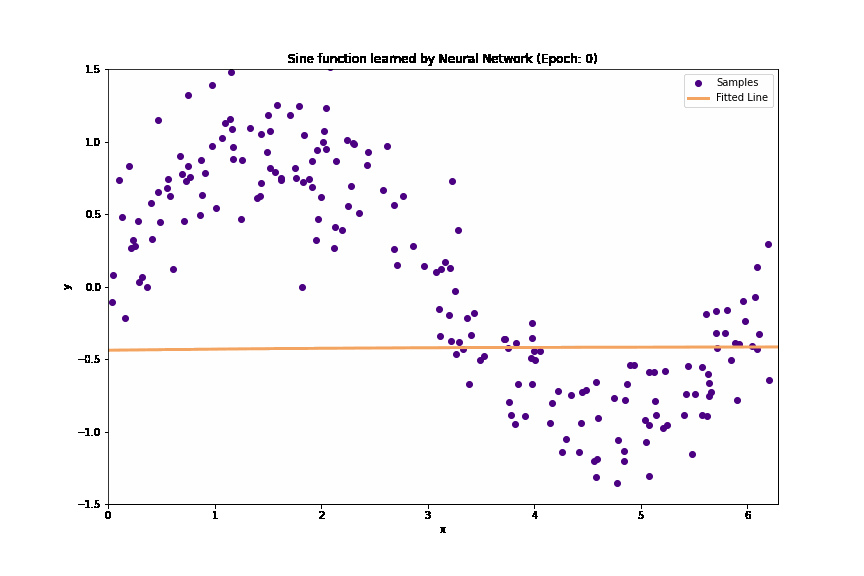

In [3]:
Image(filename = 'animation1.gif')

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 0, Train Loss: 2.5415767098479285, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 1, Train Loss: 2.154374448534738, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 2, Train Loss: 1.4440750665716093, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 3, Train Loss: 0.831592428685832, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 4, Train Loss: 0.6178764520627865, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 5, Train Loss: 0.6560431958541102, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 6, Train Loss: 0.6744589940685597, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 7, Train Loss: 0.6980010927590131, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 8, Train Loss: 0.753972500895595, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 9, Train Loss: 0.25432325814009327, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 10, Train Loss: 0.659117968483226, Train Accuracy: 0.56

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 172, Train Loss: 0.7172063452685663, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 173, Train Loss: 0.6994612604513124, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 174, Train Loss: 0.7168449028271363, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 175, Train Loss: 0.6747230843291415, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 176, Train Loss: 0.6794204838709581, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 177, Train Loss: 0.673278025379972, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 178, Train Loss: 0.6219581438060434, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 179, Train Loss: 0.7438917676069534, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 180, Train Loss: 0.7919480886451824, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 181, Train Loss: 0.7060805521515243, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 182, Train Loss: 0.680437783443378

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 346, Train Loss: 0.6450864094975941, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 347, Train Loss: 0.7005469103852421, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 348, Train Loss: 0.7180561067580596, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 349, Train Loss: 0.729342142067037, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 350, Train Loss: 0.6999881617874476, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 351, Train Loss: 0.6663220798281589, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 352, Train Loss: 0.7023513735928122, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 353, Train Loss: 0.6984525695224015, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 354, Train Loss: 0.6440224652801098, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 355, Train Loss: 0.6791901141525554, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 356, Train Loss: 0.717825837013964

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 530, Train Loss: 0.6670008894584736, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 531, Train Loss: 0.6737887516483763, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 532, Train Loss: 0.7260354217527465, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 533, Train Loss: 0.7000944562699443, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 534, Train Loss: 0.7392150936291908, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 535, Train Loss: 0.6644245581408217, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 536, Train Loss: 0.7431303978234147, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 537, Train Loss: 0.7714504621978556, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 538, Train Loss: 0.7054180757019834, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 539, Train Loss: 0.6967468954803405, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 540, Train Loss: 0.67915547412986

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 698, Train Loss: 0.656626040826181, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 699, Train Loss: 0.7026379350248891, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 700, Train Loss: 0.6613948303309322, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 701, Train Loss: 0.6602412144091415, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 702, Train Loss: 0.6387803545567732, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 703, Train Loss: 0.7032040147326657, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 704, Train Loss: 0.6763445653792657, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 705, Train Loss: 0.6803828407835519, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 706, Train Loss: 0.7401992937240991, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 707, Train Loss: 0.6687112642596162, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 708, Train Loss: 0.631333182483940

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341/531749007.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_11341

Epoch: 858, Train Loss: 0.6272443003778487, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 859, Train Loss: 0.7092314040849632, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 860, Train Loss: 0.702613086039024, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 861, Train Loss: 0.7581991371375503, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 862, Train Loss: 0.6981047227941317, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 863, Train Loss: 0.675141086661877, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 864, Train Loss: 0.6547940237397969, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 865, Train Loss: 0.6997954042829937, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 866, Train Loss: 0.7489736332783984, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 867, Train Loss: 0.7240836927813497, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 868, Train Loss: 0.7174889281043263

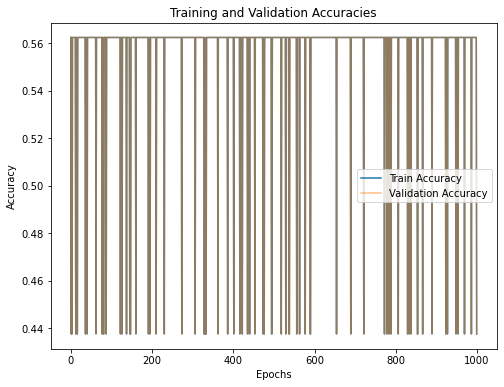

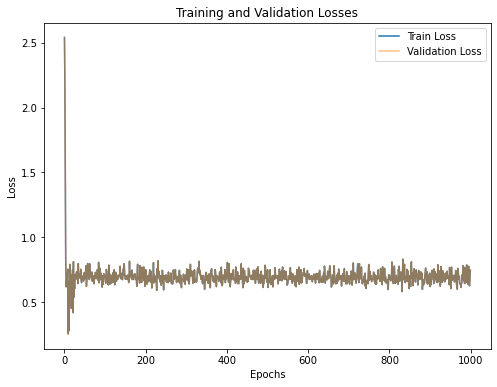

: 

In [65]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the fruit dataset
data = pd.read_csv("fruits2.csv")

# Split the data into features and labels
features = data[['area', 'eccentricity', 'Hue']].values
labels = data['class'].values

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.5, stratify=labels_encoded, random_state=42)

# Define the neural network architecture
input_size = X_train.shape[1]
hidden_size = 16
output_size = np.max(y_train) + 1

# Initialize the weights and biases
W1 = np.random.randn(hidden_size, input_size)
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size)
b2 = np.zeros((output_size, 1))

# Define the activation function (sigmoid) and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Training parameters
learning_rate = 0.3
epochs = 1000
batch_size = 30

# Lists to store training and validation accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Shuffle the training data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        # Forward pass
        batch_X = X_train_shuffled[i:i+batch_size].T
        batch_y = y_train_shuffled[i:i+batch_size]

        hidden_activations = sigmoid(np.dot(W1, batch_X) + b1)
        output_activations = sigmoid(np.dot(W2, hidden_activations) + b2)

        # Compute the loss
        num_samples = batch_X.shape[1]
        loss = -np.sum(np.log(output_activations[batch_y, np.arange(num_samples)])) / num_samples

        # Backward pass
        output_delta = output_activations
        output_delta[batch_y, np.arange(num_samples)] -= 1
        output_delta /= num_samples

        hidden_delta = np.dot(W2.T, output_delta) * sigmoid_derivative(hidden_activations)

        # Update the weights and biases
        W2 -= learning_rate * np.dot(output_delta, hidden_activations.T)
        b2 -= learning_rate * np.sum(output_delta, axis=1, keepdims=True)
        W1 -= learning_rate * np.dot(hidden_delta, batch_X.T)
        b1 -= learning_rate * np.sum(hidden_delta, axis=1, keepdims=True)

    # Evaluate the model on the training set
    hidden_activations_train = sigmoid(np.dot(W1, X_train.T) + b1)
    output_activations_train = sigmoid(np.dot(W2, hidden_activations_train) + b2)
    y_pred_train = np.argmax(output_activations_train, axis=0)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(accuracy_train)
    train_losses.append(loss)

    # Evaluate the model on the validation set
    hidden_activations_val = sigmoid(np.dot(W1, X_test.T) + b1)
    output_activations_val = sigmoid(np.dot(W2, hidden_activations_val) + b2)
    y_pred_val = np.argmax(output_activations_val, axis=0)
    accuracy_val = accuracy_score(y_test, y_pred_val)
    val_accuracies.append(accuracy_val)
    val_losses.append(loss)

    print(f"Epoch: {epoch}, Train Loss: {loss}, Train Accuracy: {accuracy_train}, Validation Accuracy: {accuracy_val}")

# Plot the training and validation accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 0, Train Loss: 1.0523413207373673, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 1, Train Loss: 1.1338957118227853, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 2, Train Loss: 0.7272005513216575, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 3, Train Loss: 0.6783557351746957, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 4, Train Loss: 0.6878885782356935, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 5, Train Loss: 0.8409839580531253, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 6, Train Loss: 0.7498583390653233, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 7, Train Loss: 0.8728623974275488, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 8, Train Loss: 0.5160669155893948, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 9, Train Loss: 0.6745760097336142, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 10, Train Loss: 0.8783031492798214, Train Accuracy: 0

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 185, Train Loss: 0.6410129847385128, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 186, Train Loss: 0.6753542664292397, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 187, Train Loss: 0.647639459667964, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 188, Train Loss: 0.6675657376724852, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 189, Train Loss: 0.7959443951995095, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 190, Train Loss: 0.674454345616264, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 191, Train Loss: 0.673223357209429, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 192, Train Loss: 0.7431609924725994, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 193, Train Loss: 0.7287655097444002, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 194, Train Loss: 0.6946244479462671, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 195, Train Loss: 0.7015514414283832,

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 359, Train Loss: 0.7123841523695071, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 360, Train Loss: 0.6731226630669422, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 361, Train Loss: 0.6512542343882013, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 362, Train Loss: 0.6975844574520754, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 363, Train Loss: 0.7316444311897413, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 364, Train Loss: 0.6617336449487838, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 365, Train Loss: 0.6986667372436026, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 366, Train Loss: 0.7335269389648553, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 367, Train Loss: 0.6644980094746982, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 368, Train Loss: 0.6734493455527947, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 369, Train Loss: 0.70559942518551

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 539, Train Loss: 0.6793365520539758, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 540, Train Loss: 0.6997139234667273, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 541, Train Loss: 0.6500312680100853, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 542, Train Loss: 0.697422899340878, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 543, Train Loss: 0.6934095476500356, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 544, Train Loss: 0.7496259291742434, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 545, Train Loss: 0.6737885458674577, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 546, Train Loss: 0.6506334247246023, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 547, Train Loss: 0.6407053609495257, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 548, Train Loss: 0.6034764809151139, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 549, Train Loss: 0.709180716515621

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 723, Train Loss: 0.7020591106018326, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 724, Train Loss: 0.675652419433592, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 725, Train Loss: 0.8015105296381512, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 726, Train Loss: 0.6797303786077431, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 727, Train Loss: 0.7094980358021892, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 728, Train Loss: 0.6572662311902879, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 729, Train Loss: 0.6412435532420926, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 730, Train Loss: 0.6759679174253865, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 731, Train Loss: 0.7992788839998195, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 732, Train Loss: 0.6322282769108254, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 733, Train Loss: 0.647635945029928

/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567703.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/69567

Epoch: 900, Train Loss: 0.7556199564882358, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 901, Train Loss: 0.7120420422471695, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 902, Train Loss: 0.6935003918982413, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 903, Train Loss: 0.6369161266151595, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 904, Train Loss: 0.6769788787989002, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 905, Train Loss: 0.6732849372183864, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 906, Train Loss: 0.7709143287033042, Train Accuracy: 0.4375, Validation Accuracy: 0.4375
Epoch: 907, Train Loss: 0.6572397435231998, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 908, Train Loss: 0.6612283907365307, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 909, Train Loss: 0.6401583093504082, Train Accuracy: 0.5625, Validation Accuracy: 0.5625
Epoch: 910, Train Loss: 0.75563925273321

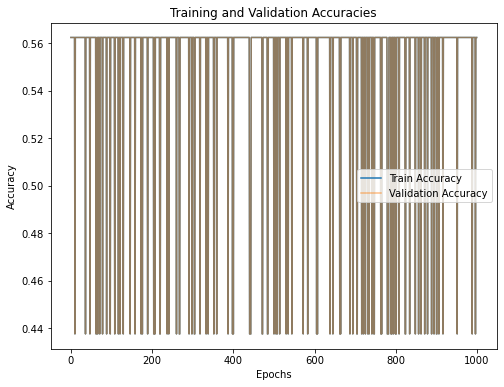

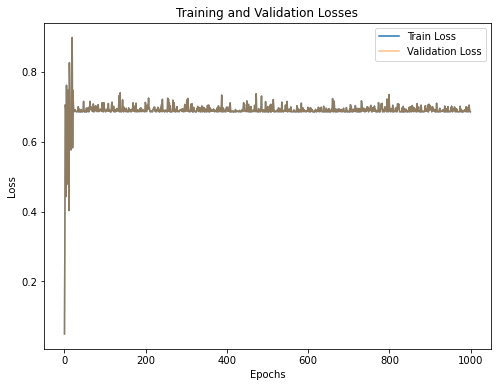

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the fruit dataset
data = pd.read_csv("fruits2.csv")

# Split the data into features and labels
features = data[['area', 'eccentricity', 'Hue']].values
labels = data['class'].values

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.5, stratify=labels_encoded, random_state=42)

# Define the neural network architecture
input_size = X_train.shape[1]
hidden_size = 16
output_size = np.max(y_train) + 1

# Initialize the weights and biases
W1 = np.random.randn(hidden_size, input_size)
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size)
b2 = np.zeros((output_size, 1))

# Define the activation function (sigmoid) and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Training parameters
learning_rate = 0.3
epochs = 1000
batch_size = 30

# Lists to store training and validation accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Shuffle the training data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        # Forward pass
        batch_X = X_train_shuffled[i:i+batch_size].T
        batch_y = y_train_shuffled[i:i+batch_size]

        hidden_activations = sigmoid(np.dot(W1, batch_X) + b1)
        output_activations = sigmoid(np.dot(W2, hidden_activations) + b2)

        # Compute the loss
        num_samples = batch_X.shape[1]
        loss = -np.sum(np.log(output_activations[batch_y, np.arange(num_samples)])) / num_samples

        # Backward pass
        output_delta = output_activations
        output_delta[batch_y, np.arange(num_samples)] -= 1
        output_delta /= num_samples

        hidden_delta = np.dot(W2.T, output_delta) * sigmoid_derivative(hidden_activations)

        # Update the weights and biases
        W2 -= learning_rate * np.dot(output_delta, hidden_activations.T)
        b2 -= learning_rate * np.sum(output_delta, axis=1, keepdims=True)
        W1 -= learning_rate * np.dot(hidden_delta, batch_X.T)
        b1 -= learning_rate * np.sum(hidden_delta, axis=1, keepdims=True)

    # Evaluate the model on the validation set
    hidden_activations_val = sigmoid(np.dot(W1, X_test.T) + b1)
    output_activations_val = sigmoid(np.dot(W2, hidden_activations_val) + b2)
    y_pred_val = np.argmax(output_activations_val, axis=0)
    accuracy_val = accuracy_score(y_test, y_pred_val)
    val_accuracies.append(accuracy_val)

    # Compute the loss on the validation set
    num_samples_val = X_test.shape[0]
    loss_val = -np.sum(np.log(output_activations_val[y_test, np.arange(num_samples_val)])) / num_samples_val
    val_losses.append(loss_val)

    # Evaluate the model on the training set
    hidden_activations_train = sigmoid(np.dot(W1, X_train.T) + b1)
    output_activations_train = sigmoid(np.dot(W2, hidden_activations_train) + b2)
    y_pred_train = np.argmax(output_activations_train, axis=0)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(accuracy_train)

    # Compute the loss on the training set
    num_samples_train = X_train.shape[0]
    loss_train = -np.sum(np.log(output_activations_train[y_train, np.arange(num_samples_train)])) / num_samples_train
    train_losses.append(loss_train)

    print(f"Epoch: {epoch}, Train Loss: {loss}, Train Accuracy: {accuracy_train}, Validation Accuracy: {accuracy_val}")

# Plot the training and validation accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Plot the training and validation losses
plt.figure(figsize=(8, 6))
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), val_losses, label='Validation Loss', alpha = 0.5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel_13608/2862498927.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/nd/l3h_t2k14fqdnbr6dbvvblth0000gn/T/ipykernel

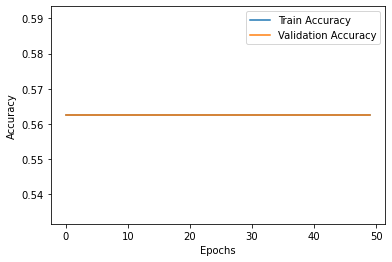

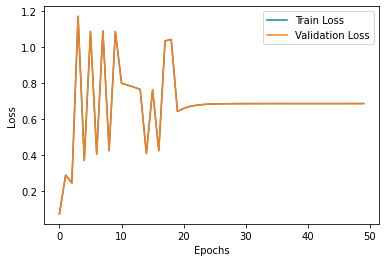

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the fruit dataset
data = pd.read_csv("fruits2.csv")

# Split the data into features and labels
features = data[['area', 'eccentricity', 'Hue']].values
labels = data['class'].values

# Encode labels to numerical values
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.5, stratify=labels_encoded, random_state=42)

# Define the neural network architecture
input_size = X_train.shape[1]
hidden_size = 16
output_size = np.max(y_train) + 1

# Initialize the weights and biases
W1 = np.random.randn(hidden_size, input_size)
b1 = np.zeros((hidden_size, 1))
W2 = np.random.randn(output_size, hidden_size)
b2 = np.zeros((output_size, 1))

# Define the activation function (sigmoid) and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Training parameters
learning_rate = 0.1
epochs = 50
batch_size = 32

# Initialize lists to store accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Shuffle the training data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    # Mini-batch training
    for i in range(0, len(X_train), batch_size):
        # Forward pass
        batch_X = X_train_shuffled[i:i+batch_size].T
        batch_y = y_train_shuffled[i:i+batch_size]

        hidden_activations = sigmoid(np.dot(W1, batch_X) + b1)
        output_activations = sigmoid(np.dot(W2, hidden_activations) + b2)

        # Compute the loss
        num_samples = batch_X.shape[1]
        loss = -np.sum(np.log(output_activations[batch_y, np.arange(num_samples)])) / num_samples

        # Backward pass
        output_delta = output_activations
        output_delta[batch_y, np.arange(num_samples)] -= 1
        output_delta /= num_samples

        hidden_delta = np.dot(W2.T, output_delta) * sigmoid_derivative(hidden_activations)

        # Update the weights and biases
        W2 -= learning_rate * np.dot(output_delta, hidden_activations.T)
        b2 -= learning_rate * np.sum(output_delta, axis=1, keepdims=True)
        W1 -= learning_rate * np.dot(hidden_delta, batch_X.T)
        b1 -= learning_rate * np.sum(hidden_delta, axis=1, keepdims=True)
        
    # Evaluate the model on the training set
    hidden_activations_train = sigmoid(np.dot(W1, X_train.T) + b1)
    output_activations_train = sigmoid(np.dot(W2, hidden_activations_train) + b2)
    y_pred_train = np.argmax(output_activations_train, axis=0)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    train_accuracies.append(accuracy_train)

    # Compute the loss on the training set
    num_samples_train = X_train.shape[0]
    loss_train = -np.sum(np.log(output_activations_train[y_train, np.arange(num_samples_train)])) / num_samples_train
    train_losses.append(loss_train)
    
    # Evaluate the model on the validation set
    hidden_activations_val = sigmoid(np.dot(W1, X_test.T) + b1)
    output_activations_val = sigmoid(np.dot(W2, hidden_activations_val) + b2)
    y_pred_val = np.argmax(output_activations_val, axis=0)
    accuracy_val = accuracy_score(y_test, y_pred_val)
    val_accuracies.append(accuracy_val)

    # Compute the loss on the validation set
    num_samples_val = X_test.shape[0]
    loss_val = -np.sum(np.log(output_activations_val[y_test, np.arange(num_samples_val)])) / num_samples_val
    val_losses.append(loss_val)

# Plotting the train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
